### **Exemplos Compressed Sensing, Sparse Representation, Sparse Sensor Placement**

---

Gabriel Oukawa <br>
Álgebra linear para ciência de dados <br>
2º Semestre de 2025

---


1. Seção 3.3 - Sparsity and Compressed Sensing - Exemplo 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize

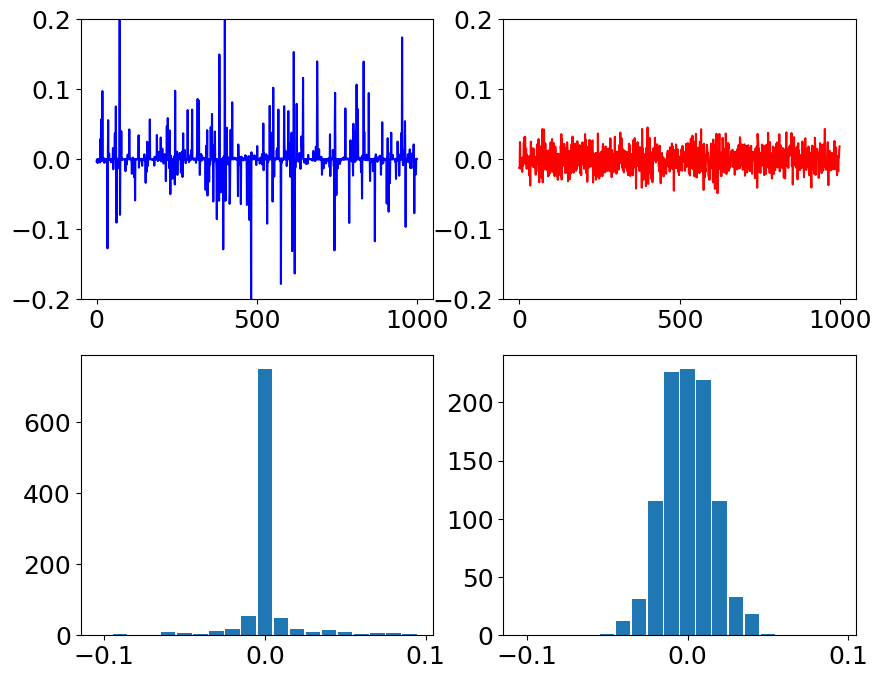

In [ ]:
plt.rcParams['figure.figsize'] = [12, 18]
plt.rcParams.update({'font.size': 18})

# Solve y = Theta * s for "s"
n = 1000 # dimension of s
p = 200  # number of measurements, dim(y)
Theta = np.random.randn(p,n)
y = np.random.randn(p)

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s_L1 = res.x

# L2 Minimum norm solution s_L2
s_L2 = np.linalg.pinv(Theta) @ y

fig,axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.reshape(-1)
axs[0].plot(s_L1,color='b',linewidth=1.5)
axs[0].set_ylim(-0.2,0.2)
axs[1].plot(s_L2,color='r',linewidth=1.5)
axs[1].set_ylim(-0.2,0.2)
axs[2].hist(s_L1,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)
axs[3].hist(s_L2,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)

plt.show()

2. Seção 3.3 - Sparsity and Compressed Sensing - Exemplo 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

In [ ]:
# Função CoSaMP
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")

        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)

        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b

        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter

    return a

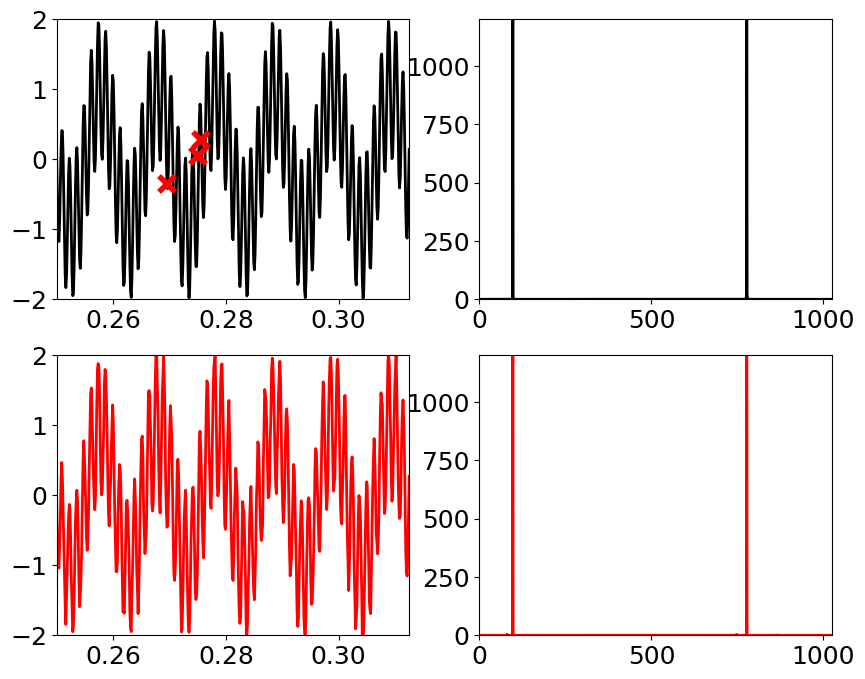

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

## Generate signal, DCT of signal
n = 8192 # points in high resolution signal
t = np.linspace(0,1,n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

## Randomly sample signal
p = 64 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
xrecon = idct(s) # reconstruct full signal

## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))

fig,axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

3. Seção 3.6 - Sparse Representation - Exemplo 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from sklearn import linear_model
from sklearn import model_selection
from scipy.optimize import minimize
from skimage.transform import resize
from matplotlib.image import imread


plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

mustache = imread(os.path.join('..','DATA','mustache.jpg'))
mustache = np.mean(mustache, -1); # Convert RGB to grayscale
mustache = (mustache/255).astype(int)
mustache = mustache.T

mat = scipy.io.loadmat(os.path.join('..','DATA','allFaces.mat'))
X = mat['faces']
nfaces = mat['nfaces'].reshape(-1)
n = mat['n']
n = int(n)
m = mat['m']
m = int(m)

In [ ]:
nTrain = 30
nTest = 20
nPeople = 20
Train = np.zeros((X.shape[0],nTrain*nPeople))
Test = np.zeros((X.shape[0],nTest*nPeople))

for k in range(nPeople):
    baseind = 0
    if k > 0:
        baseind = np.sum(nfaces[:k])
    inds = range(baseind,baseind+nfaces[k])
    Train[:,k*nTrain:(k+1)*nTrain] = X[:,inds[:nTrain]]
    Test[:,k*nTest:(k+1)*nTest] = X[:,inds[nTrain:(nTrain+nTest)]]

M = Train.shape[1]

Theta = np.zeros((120,M))
for k in range(M):
    temp = np.reshape(np.copy(Train[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall,120,1)

normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]

x1 = np.copy(Test[:,125]) # Clean image
x2 = np.copy(Test[:,125]) * mustache.reshape(n*m)
randvec = np.random.permutation(n*m)
first30 = randvec[:int(np.floor(0.3*len(randvec)))]
vals30 = (255*np.random.rand(*first30.shape)).astype(int)
x3 = np.copy(x1)
x3[first30] = vals30 # 30% occluded
x4 = np.copy(x1) + 50*np.random.randn(*x1.shape) # Random noise

X = np.zeros((x1.shape[0],4))
X[:,0] = x1
X[:,1] = x2
X[:,2] = x3
X[:,3] = x4

Y = np.zeros((120,4))
for k in range(4):
    temp = np.reshape(np.copy(X[:,k]),(m,n))
    tempSmall = resize(temp, (10, 12), anti_aliasing=True)
    Y[:,k] = np.reshape(tempSmall,120,1)

y1 = np.copy(Y[:,0])
eps = 0.01

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y1,2)})
x0 = np.linalg.pinv(Theta) @ y1 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s1 = res.x

plt.figure()
plt.plot(s1)
plt.figure()
plt.imshow(np.reshape(Train @ (s1/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x1 - Train @ (s1/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x1-Train[:,L] @ (s1[L]/normTheta[L]))/np.linalg.norm(x1)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [ ]:
## L1 Search, Mustache
y2 = np.copy(Y[:,1])
eps = 500

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y2,2)})
x0 = np.linalg.pinv(Theta) @ y2 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s2 = res.x



plt.figure()
plt.plot(s2)
plt.figure()
plt.imshow(np.reshape(Train @ (s2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x2 - Train @ (s2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x2-Train[:,L] @ (s2[L]/normTheta[L]))/np.linalg.norm(x2)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()



In [ ]:
## L1 Search, Occlusion
y3 = np.copy(Y[:,2])
eps = 1000

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y3,2)})
x0 = np.linalg.pinv(Theta) @ y3 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s3 = res.x

plt.figure()
plt.plot(s3)
plt.figure()
plt.imshow(np.reshape(Train @ (s3/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x3 - Train @ (s3/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x3-Train[:,L] @ (s3[L]/normTheta[L]))/np.linalg.norm(x3)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [ ]:
## L1 Search, Noise
y4 = np.copy(Y[:,3])
eps = 10

# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - y4,2)})
x0 = np.linalg.pinv(Theta) @ y4 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s4 = res.x

plt.figure()
plt.plot(s4)
plt.figure()
plt.imshow(np.reshape(Train @ (s4/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4[L]/normTheta[L]))/np.linalg.norm(x4)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

In [ ]:
## Least Squares Is No Good
s4L2 = np.linalg.pinv(Train) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')
plt.figure()
plt.imshow(np.reshape(x4 - Train @ (s4L2/normTheta),(m,n)).T,cmap='gray')

binErr = np.zeros(nPeople)
for k in range(nPeople):
    L = range(k*nTrain,(k+1)*nTrain)
    binErr[k] = np.linalg.norm(x4-Train[:,L] @ (s4L2[L]/normTheta[L]))/np.linalg.norm(x4)

plt.figure()
plt.bar(range(nPeople),binErr)
plt.show()

4. Seção 3.8 - Sparse Sensor Placement - Exemplo 1